### 루프를 생성하고 제어하는 방법
- 루프가 있는 그래프를 생성할 때는 실행을 종료하는 매커니즘 필요
- 일반적인 종료 조건 : END 노드로 연결되는 조건부 엣지 추가
- 그래프를 호출하거나 스트리밍할 때 그래프 재귀 제한 설정 가능

### 그래프 정의

In [1]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)

def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

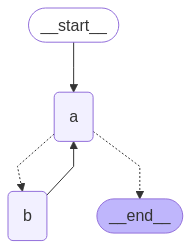

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

해당 아키텍처는 `"a"` 노드가 도구 호출 모델, `"b"` 노드가 도구를 나타내는 ReAct 에이전드와 유사

조건부 엣지에서는 "aggregate" 상태의 목록이 임계값 길이를 통과한 `route`후에 종료되어야 한다고 지정

그래프를 불러오면 종료 조건에 도달하면 `"a"`노드와 `"b"`노드 사이를 번갈아가며 이동

In [3]:
graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

### 재귀 제한을 부과
- 일부 애플리케이션에서는 주어진 종료 조건에 도달할 것이라는 보장이 없을 수 있음
- 재귀 한계를 설정할 수 있음
- 주어진 슈퍼스텝 수 후에 `GraphRecursionError`를 발생

In [4]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4}) # 재귀 한계 4로 설정
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Recursion Error


### 가지가 있는 루프
- 아래 루프를 구현하지만, 한 단계가 두 노드로 확장

In [5]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Node D sees {state["aggregate"]}')
    return {"aggregate": ["D"]}

# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)

# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "c")
builder.add_edge("b", "d")
builder.add_edge(["c", "d"], "a")
graph = builder.compile()

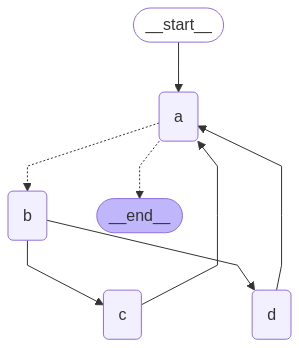

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
result = graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node C sees ['A', 'B']
Node D sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Node B sees ['A', 'B', 'C', 'D', 'A']
Node D sees ['A', 'B', 'C', 'D', 'A', 'B']
Node C sees ['A', 'B', 'C', 'D', 'A', 'B']
Node A sees ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


In [8]:
from langgraph.errors import GraphRecursionError

try:
    result = graph.invoke({"aggregate": []}, {"recursion_limit": 4}) # 재귀 4번으로 제한
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node D sees ['A', 'B']
Node C sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Recursion Error
